## About: Use MRI scan images to classify into values
## Date: 07/05/23

To classify MRI images of brain with tumors and brain with no tumors.

In [1]:
# importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import os

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
'''
# read csv with descriptors
df = pd.read_csv("/content/drive/My Drive/tox_files/descriptors.csv")
'''

'\n# read csv with descriptors\ndf = pd.read_csv("/content/drive/My Drive/tox_files/descriptors.csv")\n'

In [4]:
# save to a list image names and their bmse value
def load_images_from_folder(folder, yes_no_val): 
    
    images = []
    for filename in os.listdir(folder):
      images.append([os.path.splitext(filename)[0]+".jpg", yes_no_val])

    return images


yes_images = load_images_from_folder('/content/drive/My Drive/brain_tumor_dataset/brain_tumor_dataset/yes', 1)
no_images = load_images_from_folder('/content/drive/My Drive/brain_tumor_dataset/brain_tumor_dataset/no', 0)

In [5]:
# turn the list of image names to a dataframe
# merge the two dataframes based on bmse column
# drop duplicates and shuffle
df_yes = pd.DataFrame (yes_images, columns = ['filename', 'yes/no'])
df_no = pd.DataFrame (no_images, columns = ['filename', 'yes/no'])

df = pd.concat([df_yes, df_no], axis=0)

df = df.sample(frac=1)
df.head(5)

,filename,yes/no
104,Y8.jpg,1
50,9 no.jpg,0
58,5 no.jpg,0
88,no 95.jpg,0
102,Y31.jpg,1


In [6]:
'''
# leave only rows with specific values in specific columns (they will be our classess for classification)
df = df.query("HBA == 2 | HBA == 3")
df.head(5)
'''

'\n# leave only rows with specific values in specific columns (they will be our classess for classification)\ndf = df.query("HBA == 2 | HBA == 3")\ndf.head(5)\n'

In [7]:
# specify percentage of data used for training
TRAIN_PCT = 0.9
TRAIN_CUT = int(len(df) * TRAIN_PCT) 

# split the data to train, test and validation
df_train = df[0:TRAIN_CUT]
df_validate = df[TRAIN_CUT:]
df_test = df_train[0:4]
df_train = df_train[4:]

# print their sizes
print(f'Train size: {len(df_train)}')
print(f'Validation size: {len(df_validate)}')
print(f'Test size: {len(df_test)}')

Train size: 223
Validation size: 26
Test size: 4


In [8]:
# specify values that go into ImageDataGenerator and CNN model
IMAGES_DIR = '/content/drive/My Drive/brain_tumor_dataset/brain_tumor_dataset/both'
Y_COL = "yes/no"
HEIGHT = 300
WIDTH = 300
BATCH = 6
EPOCHS = 50

In [9]:
# improve amount of data using ImageDataGenerator
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = training_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=IMAGES_DIR,
    x_col="filename",
    y_col=Y_COL,
    target_size=(HEIGHT,WIDTH),
    batch_size=BATCH,
    class_mode='other'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_validate,
        directory=IMAGES_DIR,
        x_col="filename",
        y_col=Y_COL,
        target_size=(HEIGHT,WIDTH),
        class_mode='other')

Found 151 validated image filenames.
Found 17 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 72 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 9 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [10]:
from keras.applications import vgg16

vgg = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (HEIGHT, WIDTH, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [11]:
def lw(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='sigmoid')(top_model)
    return top_model 

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 1

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

Epoch 1/50
26/26 [==============================] - 17s 355ms/step - loss: 0.8148 - accuracy: 0.4834 - val_loss: 0.6895 - val_accuracy: 0.5294
Epoch 2/50
26/26 [==============================] - 2s 87ms/step - loss: 0.6886 - accuracy: 0.5166 - val_loss: 0.6583 - val_accuracy: 0.5294
Epoch 3/50
26/26 [==============================] - 2s 87ms/step - loss: 0.6087 - accuracy: 0.6490 - val_loss: 0.5206 - val_accuracy: 0.7059
Epoch 4/50
26/26 [==============================] - 2s 87ms/step - loss: 0.5671 - accuracy: 0.7219 - val_loss: 0.4024 - val_accuracy: 0.7647
Epoch 5/50
26/26 [==============================] - 3s 102ms/step - loss: 0.4747 - accuracy: 0.7483 - val_loss: 0.5736 - val_accuracy: 0.6471
Epoch 6/50
26/26 [==============================] - 2s 87ms/step - loss: 0.4162 - accuracy: 0.7748 - val_loss: 0.3071 - val_accuracy: 0.8235
Epoch 7/50
26/26 [==============================] - 2s 86ms/step - loss: 0.3736 - accuracy: 0.7881 - val_loss: 0.4737 - val_accuracy: 0.7059
Epoch 8/50

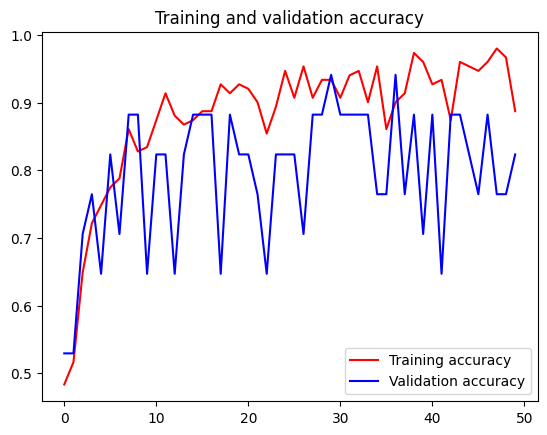

<Figure size 640x480 with 0 Axes>

In [13]:
from tensorflow.keras.models import Model

model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs=EPOCHS, 
                    validation_data=val_generator,
                    verbose = 1,
                    initial_epoch=0)

import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [14]:
'''
# loading test images paths into df
# drop duplicates
# add the column with target values
TEST_IMAGES_DIR = '/content/drive/My Drive/tox_files/test_images'
test_images = load_images_from_folder(TEST_IMAGES_DIR)
df_test = pd.DataFrame (test_images, columns = ['filename', 'id'])
df_test = df_test.drop_duplicates(subset=['id'])
df_test = pd.merge(df_test,df[['id',Y_COL]],on='id', how='left')
df_test.head(5)
'''

"\n# loading test images paths into df\n# drop duplicates\n# add the column with target values\nTEST_IMAGES_DIR = '/content/drive/My Drive/tox_files/test_images'\ntest_images = load_images_from_folder(TEST_IMAGES_DIR)\ndf_test = pd.DataFrame (test_images, columns = ['filename', 'id'])\ndf_test = df_test.drop_duplicates(subset=['id'])\ndf_test = pd.merge(df_test,df[['id',Y_COL]],on='id', how='left')\ndf_test.head(5)\n"

In [15]:
# using ImageDataGenerator on test images
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=IMAGES_DIR,
        x_col="filename",
        batch_size=1,
        shuffle=False,
        target_size=(HEIGHT,WIDTH),
        class_mode=None)

Found 4 validated image filenames.


In [16]:
# reseting the generator and predicting the values
test_generator.reset()
pred = model.predict(test_generator)

4/4 [==============================] - 0s 11ms/step


In [18]:
# add new column with predicted values
# predicted values should be beside actual values 
df_test['Predicted values'] = pred
df_test

,filename,yes/no,Predicted values
104,Y8.jpg,1,0.528841
50,9 no.jpg,0,0.038394
58,5 no.jpg,0,0.005197
88,no 95.jpg,0,0.162847
